In [1]:
%cd ..

c:\Users\c3_20\dev_nakagawa


C:\Users\c3_20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
shoot_xg_map = {
    'shoot1': 0.16,
    'shoot2': 0.03,
    'shoot3': 0.03,
    'shoot4': 0.02,
    'shoot5': 0.03,
    'shoot6': 0.03,
    'shoot7': 0.12,
    'shoot8': None,
}

In [5]:
base_dirs = glob('outputs/all_shoots/*')

output_dfs = list()
for base_dir in base_dirs:
    result_df = pd.read_csv(glob(os.path.join(base_dir, 'results_*.csv'))[0])
    shoot_df = pd.read_csv(glob(os.path.join(base_dir, 'shoots_*.csv'))[0])

    result_df['is_win'] = result_df['chance_team'] == result_df['winner']

    shoot_df = shoot_df.loc[shoot_df['shoot_x'] < 0]

    shoot_integrated_for_df = list()
    for (n_iter, n_sub_iter), group in shoot_df.groupby(['n_iter', 'n_sub_iter']):
        shoot_integrated_for_df.append({
            'n_iter': n_iter,
            'n_sub_iter': n_sub_iter,
        })

    shoot_integrated_df = pd.DataFrame(shoot_integrated_for_df)
    shoot_integrated_df['is_shoot'] = True

    result_df = result_df.merge(shoot_integrated_df, on=['n_iter', 'n_sub_iter'], how='left')
    result_df['is_shoot'] = result_df['is_shoot'].fillna(False)

    output_for_df = list()
    for n_iter, group in result_df.groupby('n_iter'):
        win_ratio = group['is_win'].mean()
        shoot_ratio = group['is_shoot'].mean()
        output_for_df.append({
            'n_iter': n_iter,
            'shoot_ratio': shoot_ratio,
            'win_ratio': win_ratio,
        })
    output_df = pd.DataFrame(output_for_df)
    output_df['exam_id'] = os.path.basename(base_dir)
    output_dfs.append(output_df)

concat_output_df = pd.concat(output_dfs, ignore_index=True)
concat_output_df

C:\Users\c3_20\AppData\Local\Temp\ipykernel_50256\3953374462.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df['is_shoot'] = result_df['is_shoot'].fillna(False)
C:\Users\c3_20\AppData\Local\Temp\ipykernel_50256\3953374462.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result_df['is_shoot'] = result_df['is_shoot'].fillna(False)
C:\Users\c3_20\AppData\Local\Temp\ipykernel_50256\3953374462.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_o

,n_iter,shoot_ratio,win_ratio,exam_id
0,1,0.07,0.05,shoot1
1,2,0.06,0.04,shoot1
2,3,0.05,0.02,shoot1
3,4,0.10,0.07,shoot1
4,5,0.09,0.02,shoot1
...,...,...,...,...
795,96,0.08,0.05,shoot8
796,97,0.09,0.07,shoot8
797,98,0.05,0.05,shoot8
798,99,0.11,0.04,shoot8


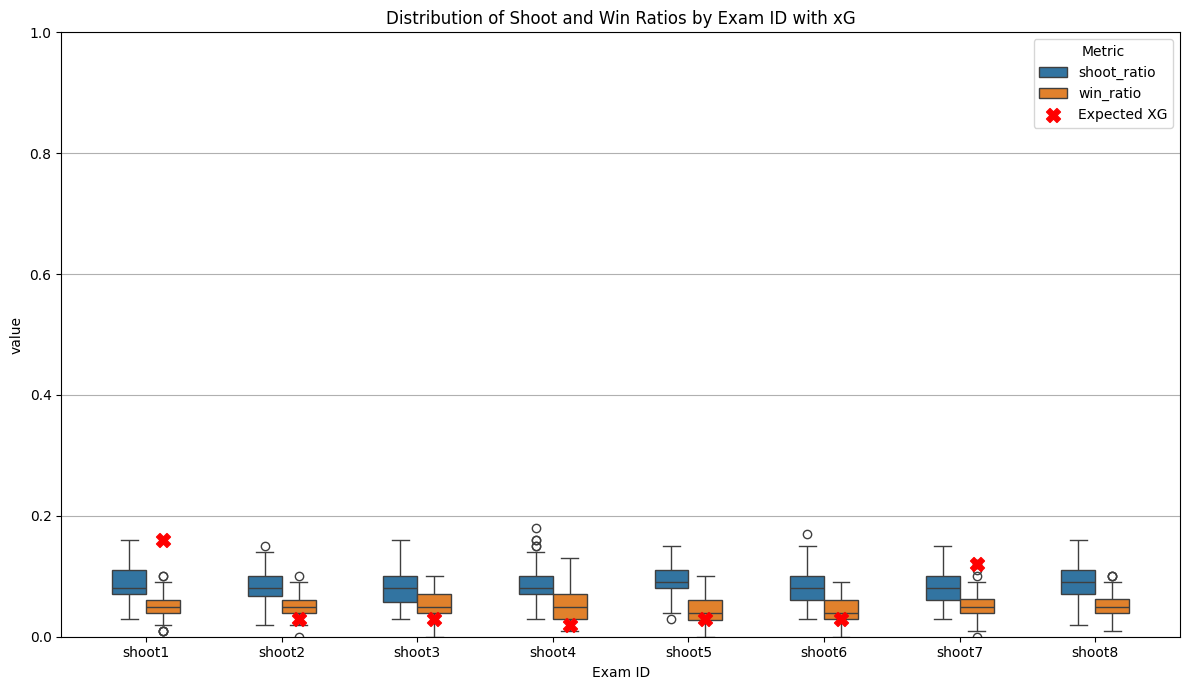

In [11]:
df = concat_output_df.copy()
df_melted = df.melt(id_vars=['n_iter', 'exam_id'], value_vars=['shoot_ratio', 'win_ratio'],
                    var_name='metric', value_name='value')

# Convert the dictionary to a DataFrame
expected_shoot_df = pd.DataFrame(list(shoot_xg_map.items()), columns=['exam_id', 'expected_value'])

# Filter out None values
expected_shoot_df = expected_shoot_df.dropna(subset=['expected_value'])

# Ensure the expected_value is numeric
expected_shoot_df['expected_value'] = pd.to_numeric(expected_shoot_df['expected_value'])

plt.figure(figsize=(12, 7))
sns.boxplot(x='exam_id', y='value', hue='metric', data=df_melted, width=0.5)

# Plot the expected values for 'shoot_ratio'
# Filter df_melted to only include 'shoot_ratio' for aligning x-axis correctly
shoot_ratio_melted = df_melted[df_melted['metric'] == 'shoot_ratio']

# To plot the expected values, we need to map the exam_id to an x-position.
# sns.boxplot implicitly orders categories, so we need to get that order.
# The x-axis for 'shoot_ratio' would be at exam_id position - 0.25 (if width is 0.5, and there are two groups)
# Or, simpler, just plot the scatter points and let matplotlib handle the x-position based on category.

# Get unique exam_ids from the melted dataframe to ensure consistent ordering on x-axis
ordered_exam_ids = df_melted['exam_id'].unique()
x_positions = {exam_id: i for i, exam_id in enumerate(ordered_exam_ids)}

# Add a column for numerical x-position for plotting
expected_shoot_df['x_pos'] = expected_shoot_df['exam_id'].map(x_positions)

# Adjust x_pos to align with the 'shoot_ratio' box plots
# Assuming 'shoot_ratio' is the first hue category
# The offset would depend on the number of hue categories and the width.
# For two categories (shoot_ratio, win_ratio) and width=0.5, the offset for the first category is -0.25
# and for the second it's +0.25.
# This assumes 'metric' order is consistent. Let's verify the order of hues first.
hue_order = df_melted['metric'].unique()
shoot_ratio_index_in_hue = list(hue_order).index('shoot_ratio')
win_ratio_index_in_hue = list(hue_order).index('win_ratio')

# Calculate the offset for 'shoot_ratio'
num_hues = len(hue_order)
# The total width used by hue groups is `width`. Each group gets `width / num_hues`.
# The center of the first group is at `-(width / 2) + (width / (2 * num_hues))`.
# For width = 0.5, num_hues = 2, center of first group is -0.25 + 0.125 = -0.125
# For two groups, the offset for the first group (index 0) is -0.125, for the second (index 1) is +0.125
# A more general way: `(idx - (num_hues - 1) / 2) * (width / num_hues)`
offset = (win_ratio_index_in_hue - (num_hues - 1) / 2) * (0.5 / num_hues)
expected_shoot_df['x_pos_adjusted'] = expected_shoot_df['x_pos'] + offset

plt.scatter(x=expected_shoot_df['x_pos_adjusted'], y=expected_shoot_df['expected_value'],
            color='red', marker='X', s=100, zorder=5, label='Expected XG')


plt.title('Distribution of Shoot and Win Ratios by Exam ID with xG')
plt.xlabel('Exam ID')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()

In [7]:
df.loc[df['exam_id'] == 'shoot4'].describe()

,n_iter,shoot_ratio,win_ratio
count,100.000000,100.000000,100.000000
mean,50.500000,0.085600,0.051100
std,29.011492,0.028615,0.024242
min,1.000000,0.030000,0.010000
25%,25.750000,0.070000,0.030000
50%,50.500000,0.080000,0.050000
75%,75.250000,0.100000,0.070000
max,100.000000,0.180000,0.130000


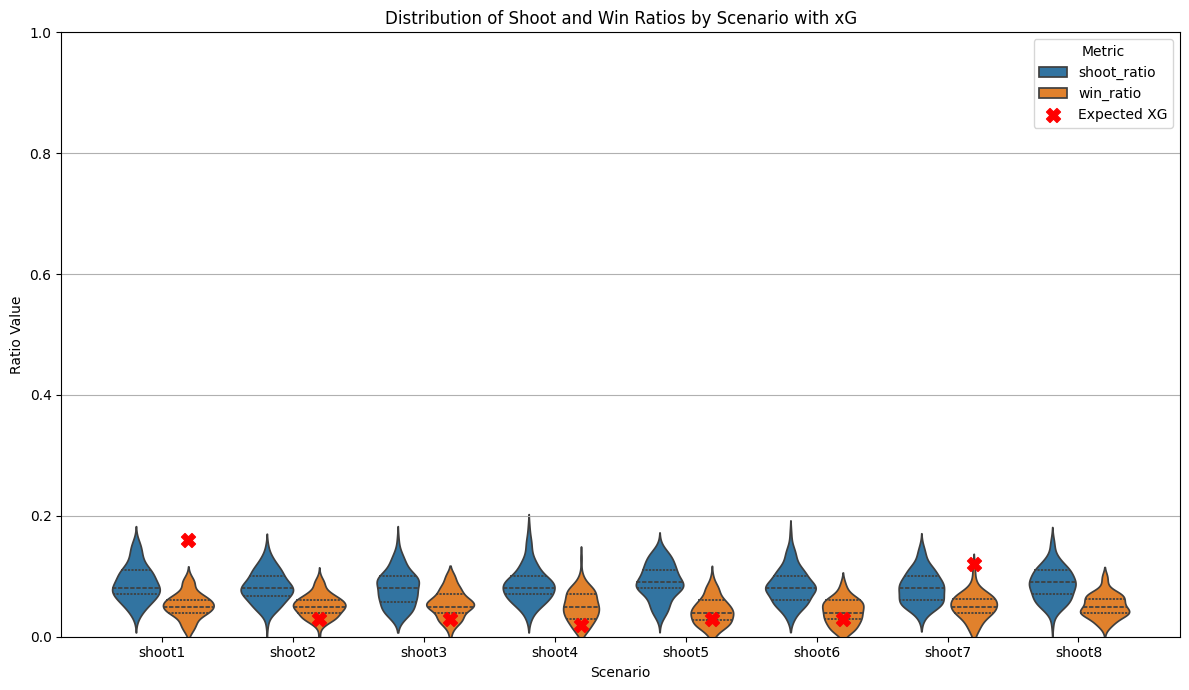

In [14]:
# Convert the dictionary to a DataFrame
expected_shoot_df = pd.DataFrame(list(shoot_xg_map.items()), columns=['exam_id', 'expected_value'])

# Filter out None values
expected_shoot_df = expected_shoot_df.dropna(subset=['expected_value'])

# Ensure the expected_value is numeric
expected_shoot_df['expected_value'] = pd.to_numeric(expected_shoot_df['expected_value'])

plt.figure(figsize=(12, 7))

# Create the violin plot
sns.violinplot(x='exam_id', y='value', hue='metric', data=df_melted, split=False, inner='quartile')

# Plot the expected values for 'shoot_ratio'
# Get unique exam_ids from the melted dataframe to ensure consistent ordering on x-axis
ordered_exam_ids = df_melted['exam_id'].unique()
x_positions = {exam_id: i for i, exam_id in enumerate(ordered_exam_ids)}

# Add a column for numerical x-position for plotting
expected_shoot_df['x_pos'] = expected_shoot_df['exam_id'].map(x_positions)

# Calculate the offset for 'shoot_ratio' to align with the violin plot.
# sns.violinplot with `split=False` still uses hue to group, and positions them side by side.
# The `width` of each violin group is by default 0.8.
# The offset calculation is the same as for boxplot with `width=0.5`.
# The default width in violinplot is 0.8.
hue_order = df_melted['metric'].unique()
shoot_ratio_index_in_hue = list(hue_order).index('shoot_ratio')
win_ratio_index_in_hue = list(hue_order).index('win_ratio')
num_hues = len(hue_order)
violin_width = 0.8 # Default violin width

offset = (win_ratio_index_in_hue - (num_hues - 1) / 2) * (violin_width / num_hues)
expected_shoot_df['x_pos_adjusted'] = expected_shoot_df['x_pos'] + offset

plt.scatter(x=expected_shoot_df['x_pos_adjusted'], y=expected_shoot_df['expected_value'],
            color='red', marker='X', s=100, zorder=5, label='Expected XG')

plt.title('Distribution of Shoot and Win Ratios by Scenario with xG')
plt.xlabel('Scenario')
plt.ylabel('Ratio Value')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()